## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [25]:
# Define the variables for the notebook
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = "Fmr1"
samp_num = "2"
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [37]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks, p = stats.ks_2samp(cumul_m, cumul_c)
            ks_list.append(ks)
            p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(p_list, log_p, ks_list, gene_list, tr_id)))
    df.columns = ["p_value","-10log(p)","ks_stat", "gene_ID","transcript_ID"]

In [38]:
# Save as a csv
df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [39]:
df

,p_value,-10log(p),ks_stat,gene_ID,transcript_ID
0,1.415132e-04,3.849203,0.211268,ND-15,FBtr0330639
1,1.978514e-07,6.703661,0.228758,ND-15,FBtr0306542
2,1.978514e-07,6.703661,0.228758,ND-15,FBtr0330638
3,2.099044e-01,0.677979,0.043333,Gs1,FBtr0300568
4,2.099044e-01,0.677979,0.043333,Gs1,FBtr0078114
...,...,...,...,...,...
1498,2.864912e-10,9.542889,0.129948,mt:ND4,FBtr0433500
1499,5.182853e-08,7.285431,0.243986,mt:ND4L,FBtr0100880
1500,1.655397e-03,2.781098,0.116190,mt:ND6,FBtr0100883
1501,3.262188e-06,5.486491,0.108179,mt:Cyt-b,FBtr0433502


In [40]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'K statistic of all Fly transcripts')

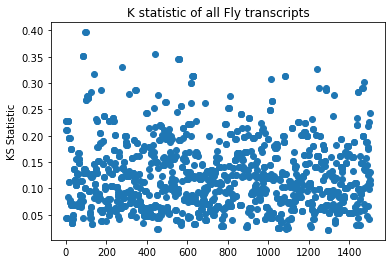

In [41]:
plt.scatter(list(range(len(df["ks_stat"]))), df["ks_stat"])
plt.ylabel("KS Statistic")
plt.title("K statistic of all Fly transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests fly')

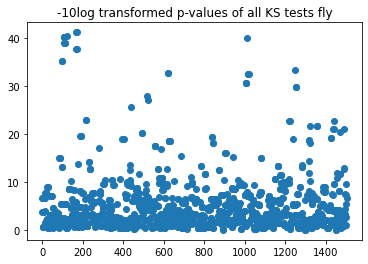

In [42]:
plt.scatter(list(range(len(df["-10log(p)"]))), df["-10log(p)"])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests fly")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

Sort these values from lowest to highest. 

In [43]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets.csv')

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

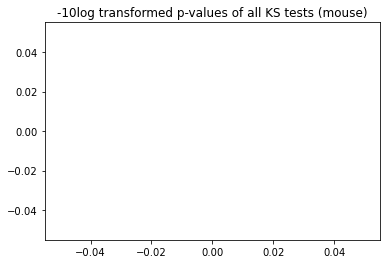

In [44]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="FLY")
plt.scatter(list(range(len(df2['-10log(p)']))), df2['-10log(p)'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

In [61]:
# print out all of the genes with P-values below a certain threshold. 
diff_dist = zip(df["transcript_ID"][df['-10log(p)'] > 30],df["gene_ID"][df['-10log(p)'] > 30])

In [62]:
list(diff_dist)

[('FBtr0079171', 'Vm26Ab'),
 ('FBtr0345439', 'Vm26Ab'),
 ('FBtr0079176', 'eIF4A'),
 ('FBtr0079175', 'eIF4A'),
 ('FBtr0307068', 'eIF4A'),
 ('FBtr0079178', 'eIF4A'),
 ('FBtr0079177', 'eIF4A'),
 ('FBtr0331201', 'eIF4A'),
 ('FBtr0304908', 'stai'),
 ('FBtr0079667', 'Akap200'),
 ('FBtr0079664', 'Akap200'),
 ('FBtr0340239', 'Akap200'),
 ('FBtr0340241', 'Akap200'),
 ('FBtr0474640', 'RpL23A'),
 ('FBtr0072805', 'RpL23A'),
 ('FBtr0082785', 'Act87E'),
 ('FBtr0346242', 'Act87E'),
 ('FBtr0082786', 'Act87E'),
 ('FBtr0082854', 'sqd'),
 ('FBtr0082801', 'B52'),
 ('FBtr0308196', 'B52'),
 ('FBtr0082806', 'B52'),
 ('FBtr0070148', 'RpL22')]

## investigate the smoothed array of a specific gene of interest

In [77]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('Akap200', 
                                                                       protein_coding, data_mutant, data_control)

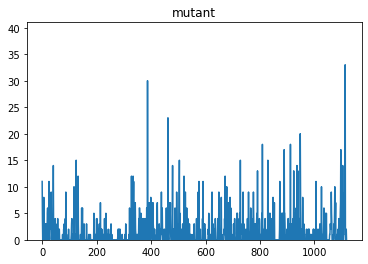

Text(0.5, 1.0, 'control')

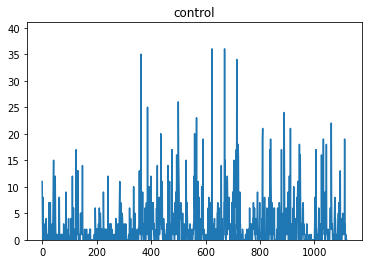

In [78]:
plt.plot(my_vec_mutant)
plt.ylim([0,max(my_vec_control)+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,max(my_vec_control)+5])
plt.title("control")

In [79]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [80]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

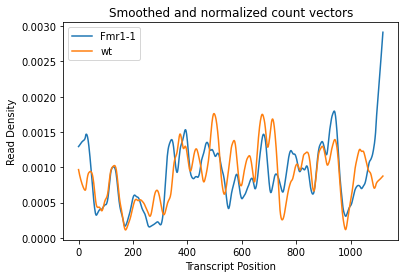

In [81]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")a
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot the correlation of the cumulative sum * The transcript position

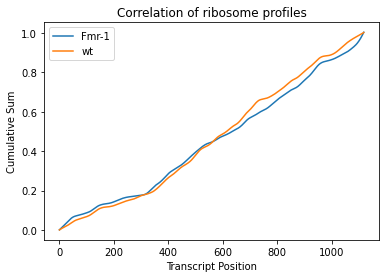

In [82]:
plt.plot(my_position, cumul_m, label = "Fmr-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [76]:
stats.ks_2samp(cumul_m, cumul_c)

KstestResult(statistic=0.2835951134380454, pvalue=5.450059054689876e-41)